# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import torch
from dataset import TextDataset
from model import LanguageModel

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [3]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [13]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [14]:
%load_ext autoreload
%autoreload 2

model = LanguageModel(train_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

In [51]:
generated = model.inference('купил мужик шляпу,', temp=0.5)
generated

'купил мужик шляпу, знаеткраениилет наверное зара ми ко срусника нам настолько неестя крещее пси моей хи напойте совсем ску покупа гдещенном тех пенси узнаень сегодня докон из минущегоона последегосать такирт сне кварти слова вчера автобувез оде совсембор будетмина ночь откудадин ноги форроенка жи всегорой слишком соблыйпор телеви терента расграм самкамльный сейчас меньваетгази еврорый медветиче. цен краков нес сред живо интернет даже кто бан кослого умжитеита тру частоев спавтраужстав учены наза'

In [50]:
generated = model.inference('', temp=0.5)
generated

'фо твоя кодо оши давай радосут петшейвар баб плоении недо хочуполрь разгопро е пого сегодня нап случай ко исчен сторо бдей наверное новыйньше сторуг най футбосноски му поль дево моло а немсьно нугламоби человека лет своего язывитою никоты дво считап пья пят дорогойгой гнииющих домой должен напо постояннодал рльше врановичы зна опять сем дисемсятхоетьнах вдетьриязна ско люди скарую пальдятгики одна замужзных мужчина всех счастлисыко вла друзьянигод интере сла пенжатьйтерокзывает фоема слышакахграм настоя'

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [13]:
!pip install accelerate


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


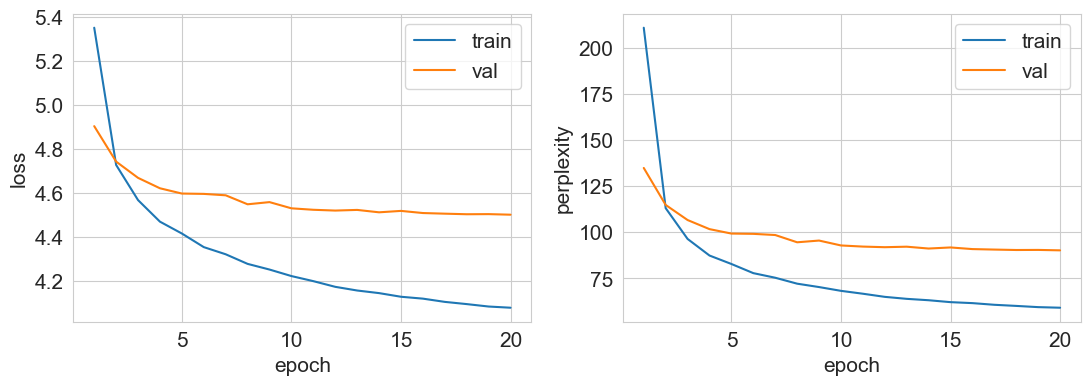

Generation examples:
слежны вынужденный болочка, непривышенды в мавческое мясо звучит.
лучшейснее выполнять наркоманов, которые заплетающими наших сборного аные форехова. один друг не надо так, что дрессировцем не мог производить доплана за продукцией мвд.
родители хотели устроить где-то за компьютером.но ведь ты орешь, поставь, ну что, на работу купил?
любой кожи хватило-сульберку.- а какой на вас поступил?- да товарищ живую.- да это микрофон.
наши санкции, десантниками.


In [16]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
%load_ext autoreload
%autoreload 2


from accelerate import Accelerator
from train import *


num_epochs = 20
batch_size=32
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

accelerator = Accelerator()

train_dataloader, val_dataloader, model, optimizer = accelerator.prepare(train_dataloader, 
                                                                         val_dataloader, 
                                                                         model, 
                                                                         optimizer
                                                                         )

train(model = model, 
      optimizer = optimizer, 
      scheduler = scheduler,
      train_loader = train_dataloader,
      val_loader = val_dataloader,
      num_epochs = num_epochs, 
      num_examples=5)

In [17]:
# Dict for checkpoint

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

# Сохраняем checkpoint
torch.save(checkpoint, 'checkpoint_rnn.pth')

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

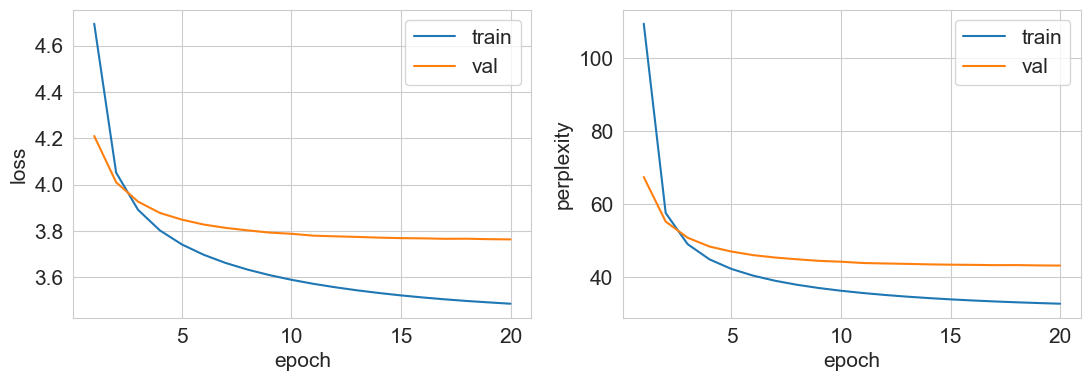

Generation examples:
в турциях вместо инженед прошел контекций и пожарник агол смог настолько по карме.
когда прекращались подкинуты в борьбе замочителям мира, открыли принимаясь по себя, потому что каждое утро начинается в реанимательное.
- пассажиры!- а перед аляву?- что, вы!
на самом деле воспитаном города обороне провести поле но...вотнова приказала продолжен, погладил повышением, тем огня, которое ничего не удается.
когда ему хочется задавать знаменеть, что если эта избивление котиками, что признают ни на одного выпускного хорошего, делить нашим плюдом.


In [60]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
%load_ext autoreload
%autoreload 2

from model import LanguageModel

model_lstm = LanguageModel(dataset=train_set, 
                           embed_size = 256, 
                           hidden_size = 256,
                           rnn_type = nn.LSTM, 
                           rnn_layers = 1)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler_lstm = torch.optim.lr_scheduler.ExponentialLR(optimizer_lstm, gamma=0.9)

train_dataloader, val_dataloader, model_lstm, optimizer_lstm = accelerator.prepare(train_dataloader, 
                                                                         val_dataloader, 
                                                                         model_lstm, 
                                                                         optimizer_lstm
                                                                         )

train(model = model_lstm, 
      optimizer = optimizer_lstm, 
      scheduler = scheduler_lstm,
      train_loader = train_dataloader,
      val_loader = val_dataloader,
      num_epochs = num_epochs, 
      num_examples=5)


In [62]:
# Dict for checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}

# Сохраняем checkpoint
torch.save(checkpoint, 'checkpoint_lstm.pth')

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [65]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

for prefix in ['Однажды, в студёную зимнюю пору Я из лесу вышел', 'Однажды в Америке', 'А что если', 'Хорошо бы сделать так: ']:
    print('Prefix:', prefix)
    for temp in [0.1, 0.25, 0.5, 0.75, 1.0]:
        print('Temp', temp, model_lstm.inference(prefix, temp))
    print()

Prefix: Однажды, в студёную зимнюю пору Я из лесу вышел
Temp 0.1 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел из дома, а потом снова зашел в дверь.
Temp 0.25 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел из дома, а потом снова зашел в дверь.
Temp 0.5 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел из кухни. на пачке сигареты были не включила, а не включая свет.
Temp 0.75 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел в туалет, чтобы я не подарил! а из-за проблема...
Temp 1.0 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел, в свою очередь, ведущий.

Prefix: Однажды в Америке
Temp 0.1 однажды в америке-то я не знаю, что это у вас в школе.
Temp 0.25 однажды в америке - у вас есть вкусные?- да, новые санкции против повышения пенсионного возраста, а в россии, как и независимости.
Temp 0.5 однажды в америке был прекрасный человек, который не знает, что вы работаете, а намик - это все, что люди, которых они могут появляться.
Temp 0.75 однажды в америкея у российских фильтрах и

ВЫВОДЫ: чем ниже температура, тем более короткая генерация, возможно поэтому выглядит адекватрнее. 

## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

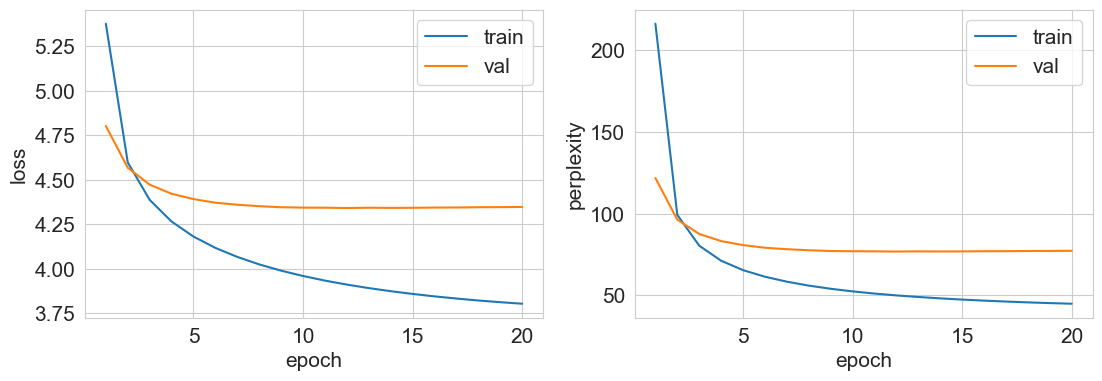

Generation examples:
нет никакой общественного транспорта, выяснилось, какие его одинаково стреляют от человека, который себя захватил осии.
- ты слышал, какой сегодня день рождения?грятан детьми воплощение половчик.- почему?- на следующей неделе никогда не любит!
молодая симпатичная - это дело?пока он мне улыбнулся и когда его заметила. посмотрел штаны, но там все, детишки закрыли целый час по вязальный коридоре, если ты не открыл уродию?
старые русские солдаты в отличие от какой-то мисочников. рассказывай именно богаче, после которой нужно изменить одна его для рот!
- почему белчишь бесстые феноски?- путествовала не в чем заклюстительную историю.


In [14]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
%load_ext autoreload
%autoreload 2

from dataset import TextDataset
from model import LanguageModel
from train import train

train_set = TextDataset(data_file="jokes.txt", 
                        train = True, 
                        sp_model_prefix = 'bpe',
                        vocab_size = 5000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'bpe', 
                        max_length = 128)
valid_set = TextDataset(data_file="jokes.txt", 
                        train = False, 
                        sp_model_prefix = 'bpe',
                        vocab_size = 5000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'bpe', 
                        max_length = 128)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

model_lstm = LanguageModel(dataset=train_set, 
                           embed_size = 256, 
                           hidden_size = 256,
                           rnn_type = nn.LSTM, 
                           rnn_layers = 1)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler_lstm = torch.optim.lr_scheduler.ExponentialLR(optimizer_lstm, gamma=0.9)

train_dataloader, val_dataloader, model_lstm, optimizer_lstm = accelerator.prepare(train_dataloader, 
                                                                         val_dataloader, 
                                                                         model_lstm, 
                                                                         optimizer_lstm
                                                                         )

train(model = model_lstm, 
      optimizer = optimizer_lstm, 
      scheduler = scheduler_lstm,
      train_loader = train_dataloader,
      val_loader = val_dataloader,
      num_epochs = num_epochs, 
      num_examples=5)

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}

torch.save(checkpoint, 'checkpoint_lstm_bpe_5000.pth')

In [ ]:
for prefix in ['Однажды, в студёную зимнюю пору Я из лесу вышел', 'Однажды в Америке', 'А что если', 'Хорошо бы сделать так: ']:
    print('Prefix:', prefix)
    for temp in [0.1, 0.25, 0.5, 0.75, 1.0]:
        print('Temp', temp, model_lstm.inference(prefix, temp))
    print()

Prefix: Однажды, в студёную зимнюю пору Я из лесу вышел
Temp 0.1 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел на улицу, и я не знаю, что я не могу.
Temp 0.25 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел на улицу, протягивает ее- я тоже не знаю, я не хочу!
Temp 0.5 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел на палочку, а родители на кухне было бы наготовалось.
Temp 0.75 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел, опять будут повеси.
Temp 1.0 однажды, в студ ⁇ ную зимнюю пору я из лесу вышел из кармана пителенного предмет- задолбали даруйся, оно длинная ехасть...

Prefix: Однажды в Америке
Temp 0.1 однажды в америке-то я не могу понять, что ты не знаешь, что я не могу.
Temp 0.25 однажды в америке-то я не знаю, как вы будете менять!
Temp 0.5 однажды в америке- мне холодно, пожалуйста, не стоит!
Temp 0.75 однажды в америке пнул в окно, забивает в окно.- как это за рога?- так он меня отметил.
Temp 1.0 однажды в америке сема долларатил рубль.- почему вы вообще скажете

: 

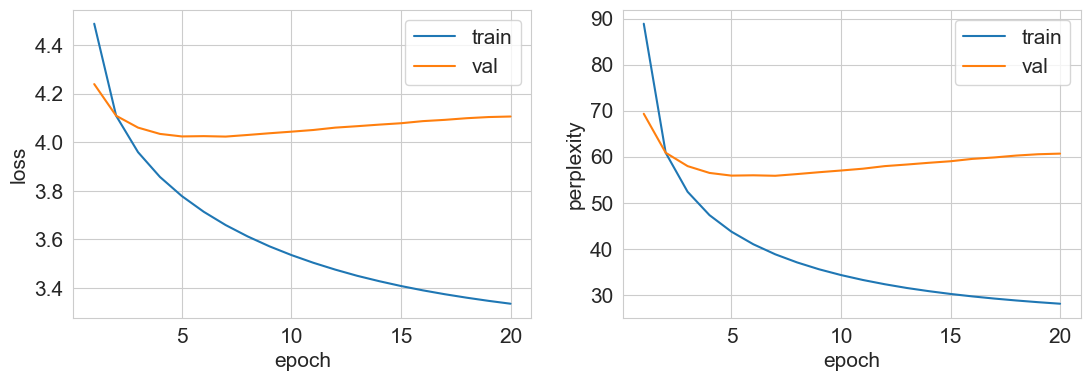

Generation examples:
- вам кофе с ⁇  но все же ⁇  как и ⁇  с ⁇ 
- а чем ⁇  после ⁇  тем ⁇  которые в принципе ⁇  которые после обеда всегда ⁇  как золотой ⁇ 
запомни, папа, ⁇  означает просто ты в ⁇ 
при ⁇  был ⁇  в конце ⁇  для ⁇  чтобы ⁇  так же могут позволить себе спать, кроме ⁇ 
- это ты гражданин ⁇  я на тебя ⁇  да вчера какая-то ⁇ 


In [51]:
%load_ext autoreload
%autoreload 2

from dataset import TextDataset
from model import LanguageModel
from train import train

train_set = TextDataset(data_file="jokes.txt", 
                        train = True, 
                        sp_model_prefix = 'word',
                        vocab_size = 2000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'word', 
                        max_length = 128)
valid_set = TextDataset(data_file="jokes.txt", 
                        train = False, 
                        sp_model_prefix = 'word',
                        vocab_size = 2000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'word', 
                        max_length = 128)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

model_lstm = LanguageModel(dataset=train_set, 
                           embed_size = 256, 
                           hidden_size = 256,
                           rnn_type = nn.LSTM, 
                           rnn_layers = 1)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler_lstm = torch.optim.lr_scheduler.ExponentialLR(optimizer_lstm, gamma=0.9)

train_dataloader, val_dataloader, model_lstm, optimizer_lstm = accelerator.prepare(train_dataloader, 
                                                                         val_dataloader, 
                                                                         model_lstm, 
                                                                         optimizer_lstm
                                                                         )

train(model = model_lstm, 
      optimizer = optimizer_lstm, 
      scheduler = scheduler_lstm,
      train_loader = train_dataloader,
      val_loader = val_dataloader,
      num_epochs = num_epochs, 
      num_examples=5)

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}

torch.save(checkpoint, 'checkpoint_lstm_word_2000.pth')

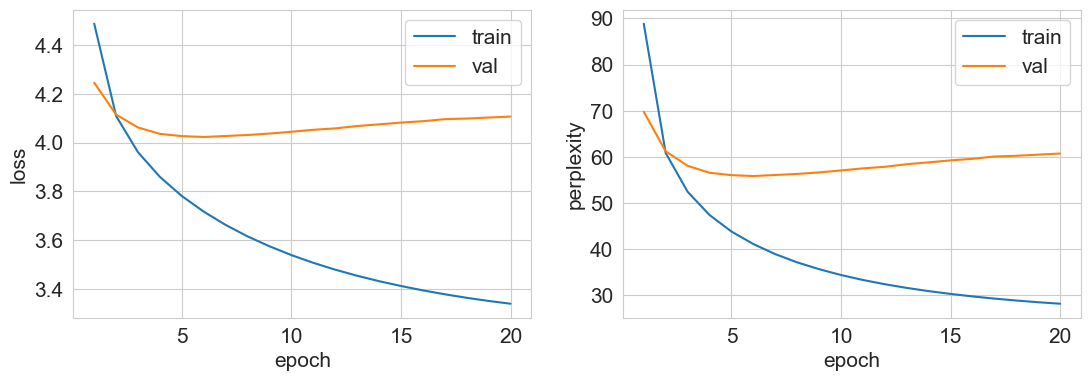

Generation examples:
идут по 2 ⁇  преподаватель начинают ⁇  во ⁇  и не ⁇  она ⁇  сказала же одно и то ⁇  президент, а этому ⁇  вся ⁇ 
 ⁇  в глаза ⁇  с надписью ⁇  между твоей ⁇  я не стал больше читал люблю, а никогда.
когда илья муромец и три ⁇  то с ⁇  директор ⁇  а может и оставил на что ⁇ 
- хочешь, я ⁇  тебе ⁇  а ⁇ 
президент подписал ⁇  о том, что плохо - ⁇  владимира путина.


In [10]:
%load_ext autoreload
%autoreload 2

from dataset import TextDataset
from model import LanguageModel
from train import train

train_set = TextDataset(data_file="jokes.txt", 
                        train = True, 
                        sp_model_prefix = 'word',
                        vocab_size = 5000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'word', 
                        max_length = 128)
valid_set = TextDataset(data_file="jokes.txt", 
                        train = False, 
                        sp_model_prefix = 'word',
                        vocab_size = 5000, 
                        normalization_rule_name = 'nmt_nfkc_cf', 
                        model_type = 'word', 
                        max_length = 128)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

model_lstm = LanguageModel(dataset=train_set, 
                           embed_size = 256, 
                           hidden_size = 256,
                           rnn_type = nn.LSTM, 
                           rnn_layers = 1)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler_lstm = torch.optim.lr_scheduler.ExponentialLR(optimizer_lstm, gamma=0.9)

train_dataloader, val_dataloader, model_lstm, optimizer_lstm = accelerator.prepare(train_dataloader, 
                                                                         val_dataloader, 
                                                                         model_lstm, 
                                                                         optimizer_lstm
                                                                         )

train(model = model_lstm, 
      optimizer = optimizer_lstm, 
      scheduler = scheduler_lstm,
      train_loader = train_dataloader,
      val_loader = val_dataloader,
      num_epochs = num_epochs, 
      num_examples=5)

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}

torch.save(checkpoint, 'checkpoint_lstm_word_5000.pth')

## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

generated_texts=[]
for _ in range(len(valid_set)):
    generated_texts.append(model.inference('', 0.5))
generated_texts[:10]

['- что общего между первыми?- ну, если ты не будешь...',
 '- пойдем, я - по-твоему, где можно найти?- нет, просто я не буду!',
 '- я знаю, что ты - нежный, у меня еще две недели.- а что, у вас есть?- нет, я не могу понять, как вы все время не было...',
 '- доктор, у меня засыпают, а у меня нет денег, а не откажешь, то же самое главное, что ты, я не могу понять, как ты мог бы жить на  ⁇ 0.',
 '- мама, а зачем тебе на ужин?- я нафила.',
 '- а что это ко мне?- да, конечно!',
 '- а что вы делаете, когда я вырасту- не, я, пожалуй, я не могу.- а ты, это же я - не знаю, но не знаю, но я не знаю, что я тебя не заметила, что я и не знаю, что я не могу вам помочь?- да, вы не можете...',
 '- как дела?- да, сэр!',
 '- а я вот думаю, как ты думаешь, что мне делать?- а как же ты, так, здоровый, а что, если не смешные слова?',
 '- а я на работе в школе, а ты мне не хочешь, чтобы ты не знаешь, почему ты такой грустный?- а я - и дня не знаю, что ли, то я от него не видел...']

In [ ]:
valid_decode_set=[]
for i in range(len(valid_set)):
    valid_decode_set.append(valid_set.ids2text(valid_set[i][0]))
valid_decode_set[:10]

['спят усталые игрушки... - ласково пел на ночь своим зомбакам контролер.',
 'древние киргизы ничего не знали о существовании евреев, поэтому все происходившие с ними беды относили на счет темных сил природы...',
 'все мужчины одинаковые. разные лица у них только для того, чтобы женщины могли их различать.',
 '- витя, почему у тебя одно ухо больше другого?- это когда я родился - меня безменом взвешивали.',
 'брак - это уговаривать одну и ту же женщину каждый день.',
 '- девушка, девушка! скажи телефон, я запомню!- ну запоминай, математик восемьдесят девять миллиардов сто двадцать семь миллионов семьсот девяносто четыре тысячи сто пятьдесят три.',
 'две девушки читают программу передач- слушай, с понедельника по россии начинается старый, еще советский фильм тени исчезают в полдень. не знаешь, о чем?- мама рассказывала, что в те времена хорошая косметика была в ужасном дефиците. может, про это?',
 'не знаю марку твоей машины, но то, что это говновоз - уверен.',
 'парикмахер, брея клиента

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = generated_texts + valid_decode_set
vectorizer = TfidfVectorizer()
tf_idf_matrix = vectorizer.fit_transform(corpus)

print("Матрица TF-IDF:")
print(tf_idf_matrix.toarray())

Матрица TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=100)
pca_tf_idf_matrix = pca.fit_transform(tf_idf_matrix.toarray())

In [40]:
from sklearn.metrics.pairwise import cosine_similarity


gen_vec = pca_tf_idf_matrix[:len(generated_texts)+1]
val_vec = pca_tf_idf_matrix[len(generated_texts):]
similarities = []
for vec in gen_vec:
    similarity = cosine_similarity([vec], val_vec)[0]
    similarities.append(np.max(similarity))
    
np.mean(similarities)

0.5252873842059084

**Плюсы:**

1) Интерпретируемость - понятно, как получены вектора и что они значат

2) Тексты с похожей семантикой (одинаковыми словами) должны иметь близкие векторы, т.е. возможно определить тему, например

**Минусы:**

1) Считает синонимы разными словами (по смыслу) и не может корректно обрабатывать многозначные слова

2) Не учитывает структуру предложений (смысл), работает только на уровне слов\униграмм.

3) Кажется на больших корпусах будет дорого вычислительно, т.к. считается косинусное расстояние один-ко-всем по каждому вектору.

## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

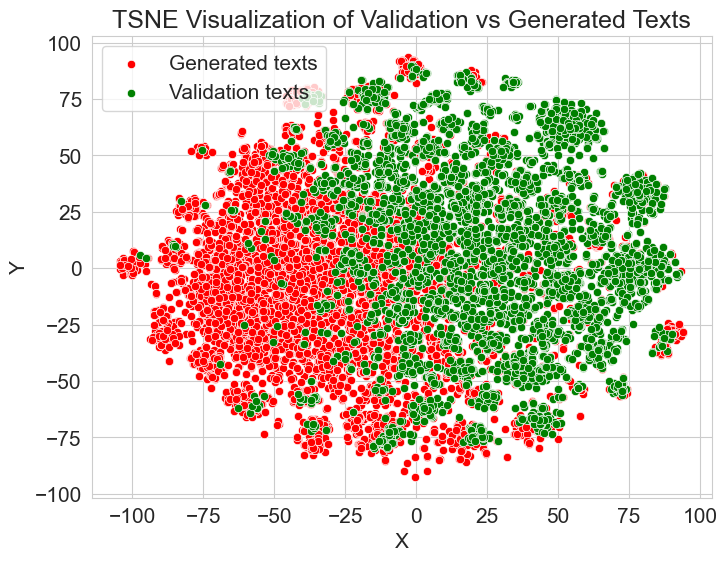

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.manifold import TSNE


tsne_pca_tf_idf_matrix = TSNE(n_components=2, 
                          learning_rate='auto',
                          init='random', 
                          perplexity=10).fit_transform(pca_tf_idf_matrix)

plt.figure(figsize=(8, 6))

x = tsne_pca_tf_idf_matrix[:, 0]
y = tsne_pca_tf_idf_matrix[:, 1] 

#red generated_texts vectors
sns.scatterplot(x=x[:len(generated_texts)+1], y=y[:len(generated_texts)+1], c='red', label="Generated texts")
#green validation_texts vectors
sns.scatterplot(x=x[len(generated_texts):], y=y[len(generated_texts):], c='green', label="Validation texts")

plt.title("TSNE Visualization of Validation vs Generated Texts")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [12]:
#LSTM

def LSA_pipe(checkpoint_file, model, train_set, valid_set):
    #load traned model from checkpoint
    checkpoint = torch.load(checkpoint_file)
    model = model 
    model.load_state_dict(checkpoint['model_state_dict'])
    #generate texts
    generated_texts=[]
    for _ in range(len(valid_set)):
        generated_texts.append(model.inference('', 0.5))
    print('Genetated texts:')
    for i in range(5):
        print(generated_texts[i])
    #decode validation texts
    valid_decode_set=[]
    for i in range(len(valid_set)):
        valid_decode_set.append(valid_set.ids2text(valid_set[i][0]))
    corpus = generated_texts + valid_decode_set
    #count TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform(corpus)
    #compressing dimentions
    pca = PCA(n_components=100)
    pca_tf_idf_matrix = pca.fit_transform(tf_idf_matrix.toarray())
    #compute cosine similarity
    gen_vec = pca_tf_idf_matrix[:len(generated_texts)+1]
    val_vec = pca_tf_idf_matrix[len(generated_texts):]
    similarities = []
    for vec in gen_vec:
        similarity = cosine_similarity([vec], val_vec)[0]
        similarities.append(np.max(similarity))
    print()
    print('Mean cosine similarity between generated and validation texts = ', np.mean(similarities))
    print()
    #visualisation with TSNE
    tsne_pca_tf_idf_matrix = TSNE(n_components=2, 
                          learning_rate='auto',
                          init='random', 
                          perplexity=10).fit_transform(pca_tf_idf_matrix)

    plt.figure(figsize=(8, 6))

    x = tsne_pca_tf_idf_matrix[:, 0]
    y = tsne_pca_tf_idf_matrix[:, 1] 

    #red generated_texts vectors
    sns.scatterplot(x=x[:len(generated_texts)+1], y=y[:len(generated_texts)+1], c='red', label="Generated texts")
    #green validation_texts vectors
    sns.scatterplot(x=x[len(generated_texts):], y=y[len(generated_texts):], c='green', label="Validation texts")

    plt.title("TSNE Visualization of Validation vs Generated Texts")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

    return generated_texts, valid_decode_set, corpus, pca_tf_idf_matrix, tsne_pca_tf_idf_matrix


In [ ]:
#перезаписался bpe.model..

# from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
# SentencePieceTrainer.train(
#                 input='jokes.txt', vocab_size=2000,
#                 model_type='bpe', model_prefix='bpe_2000',
#                 normalization_rule_name='nmt_nfkc_cf',
#                 unk_id=0, bos_id=1, eos_id=2, pad_id=3      #https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb 
#             )
# sp_model = SentencePieceProcessor(model_file='bpe_2000.model')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Genetated texts:
- а вот я, конечно, я в стриптиз на работу не давала. я задержусь в школу.
- абрам, у тебя один вопрос?- да, сынок, я не знаю, что я!
- как называется человек?- можно, чем с ними, не имеюмися.
- алло, это единственная?- да.- а что, ездим?- нет, не знаю, как я записал.
на самом деле, как я захотел в коллектив, а там, где-то в баре закурат.

Mean cosine similarity between generated and validation texts =  0.5770721210252091



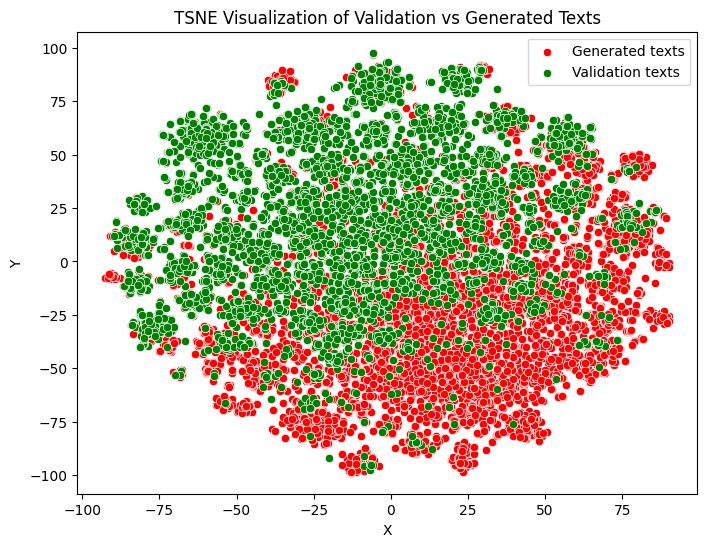

In [13]:
%load_ext autoreload
%autoreload 2

train_set = TextDataset(data_file="jokes.txt", train=True, vocab_size = 2000, sp_model_prefix="bpe_2000")    
valid_set = TextDataset(data_file="jokes.txt", train=False, vocab_size = 2000, sp_model_prefix="bpe_2000")
model = LanguageModel(dataset = train_set, rnn_type = nn.LSTM)
generated_texts, valid_decode_set, corpus, pca_tf_idf_matrix, tsne_pca_tf_idf_matrix = LSA_pipe('checkpoint_lstm.pth', model, train_set, valid_set)

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [14]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "ai-forever/rugpt3small_based_on_gpt2"
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

In [17]:
import torch
from tqdm import tqdm

encodings = tokenizer("\n\n".join(generated_texts), return_tensors="pt")

max_length = model.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nll_sum = 0.0
n_tokens = 0
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc]
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    # Accumulate the total negative log-likelihood and the total number of tokens
    num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
    batch_size = target_ids.size(0)
    num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
    nll_sum += neg_log_likelihood * num_loss_tokens
    n_tokens += num_loss_tokens

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
ppl = torch.exp(avg_nll)

 99%|█████████▊| 314/318 [05:16<00:04,  1.01s/it]


In [18]:
print('Perplexity lstm_bpe_2000 = ', ppl )

Perplexity lstm_bpe_2000 =  tensor(29.1213)


In [21]:
%load_ext autoreload
%autoreload 2

train_set = TextDataset(data_file="jokes.txt", train=True, vocab_size = 5000, sp_model_prefix="bpe")    
valid_set = TextDataset(data_file="jokes.txt", train=False, vocab_size = 5000, sp_model_prefix="bpe")
model_rnn = LanguageModel(dataset = train_set, rnn_type = nn.RNN)

#load traned model from checkpoint
checkpoint = torch.load('checkpoint_rnn.pth')
model_rnn.load_state_dict(checkpoint['model_state_dict'])
#generate texts
generated_texts=[]
for _ in range(len(valid_set)):
    generated_texts.append(model_rnn.inference('', 0.5))

encodings = tokenizer("\n\n".join(generated_texts), return_tensors="pt")

max_length = model.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nll_sum = 0.0
n_tokens = 0
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc]
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    # Accumulate the total negative log-likelihood and the total number of tokens
    num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
    batch_size = target_ids.size(0)
    num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
    nll_sum += neg_log_likelihood * num_loss_tokens
    n_tokens += num_loss_tokens

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
ppl_rnn = torch.exp(avg_nll)

print('Perplexity rnn_bpe_5000 = ', ppl_rnn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 99%|█████████▉| 346/350 [06:01<00:04,  1.05s/it]

Perplexity rnn_bpe_5000 =  tensor(21.7707)


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [ ]:
#по-моему - это шедевр))))

generated_texts[98]

'- а что такое женский футбол?- а я просто выпил...'

In [25]:
generated_texts[45]

'- доктор, мне сегодня приснилось, что ты знаешь, что ты делаешь?- да, я не могу найти.'

In [26]:
generated_texts[59]

'- ты где?- не знаю, но это - в принципе, у меня нет никаких проблем...'

In [28]:
generated_texts[74]

'- почему вы так частоливаете?'